# All plots


This notebooks tries to collect all plots, tables, calculations used in the manuscript from the messy spread of notebooks that we have produced.

# Setup 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import json 
import pandas as pd 
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

# Useful functions 

In [5]:

import matplotlib.pyplot as plt 
from priors import priors_dict
import numpy as np 
import json
import pandas as pd 
import corner
import scienceplots

def load_data(path,variables_to_plot):


    try:
        df_posterior = pd.read_parquet(path)  

    except:
        # Opening JSON file
        f = open(path)
        data = json.load(f)
        f.close()
        #Make it a dataframe. 
        df_posterior = pd.DataFrame(data["posterior"]["content"]) 


    #Make omega into nHz
    df_posterior["omega_gw"] = df_posterior["omega_gw"]*1e9
    df_posterior["h"] = df_posterior["h"]*1e15

    y_post = df_posterior[variables_to_plot].to_numpy()

    medians = df_posterior[variables_to_plot].median()
    variances = df_posterior[variables_to_plot].var()



    return_code = 0
    return y_post, return_code,df_posterior[variables_to_plot].median()







from parse import * 


def drop_braces(string_object):

    string_object = string_object.replace('{', '')
    string_object = string_object.replace('}', '')
    return string_object


def extract_value_from_title(title_string):

    template = '$\\{param_name}$ = ${value}_{lower}^{upper}$'

    parsed_output = parse(template, title_string)

    if parsed_output is None: #Handles h which is not a greek letter
        template = '${param_name}$ = ${value}_{lower}^{upper}$'
        parsed_output = parse(template, title_string)



    

    return parsed_output['param_name'],drop_braces(parsed_output['value']),drop_braces(parsed_output['lower']),drop_braces(parsed_output['upper'])

#https://stackoverflow.com/questions/32923605/is-there-a-way-to-get-the-index-of-the-median-in-python-in-one-command
def argmedian(x):
  return np.argpartition(x, len(x) // 2)[len(x) // 2]

def stacked_corner(list_of_files,number_of_files_to_plot,variables_to_plot,ranges,injection_parameters,labels,axes_scales,savefig=None,logscale=False):

    y = []
    fig= None 
    i = 0

    #while i < number_of_files_to_plot:

    df_medians = []
    for j in range(len(list_of_files)):
        f = list_of_files[j]
        yi,code,median_values = load_data(f,variables_to_plot)
        print("DF median values = ")
        print(median_values/injection_parameters)

        if code == 0:
            y.extend([yi])
            df_medians.extend([median_values])
            i += 1

        if i > number_of_files_to_plot:
            break
        
        print(i, f)

    plt.style.use('science')

    meta_df = pd.concat(df_medians,axis=1)
    final_medians_df = meta_df.transpose()
    

    std_medians = final_medians_df.std()
    mean_medians = final_medians_df.mean()
    coefficient_of_variation = std_medians / mean_medians
    print("result:")
    print(coefficient_of_variation)

    num_params = len(variables_to_plot)
    
    title_values = np.zeros((num_params,number_of_files_to_plot)) #an array with shape number of parameters x number of noise realisations 
    title_upper = np.zeros((num_params,number_of_files_to_plot)) 
    title_lower = np.zeros((num_params,number_of_files_to_plot))

   
    

    for i in range(number_of_files_to_plot): #for each noise realisation 

        k = i 
        if k ==2:
            k = k+1 #convoluted way of skipping C2 color




        if logscale:
            yplot = np.log10(y[i])
            injection_parameters = np.log10(injection_parameters)
            #ranges = np.log10(ranges)
        else:
            yplot = y[i]
        
        print("ranges =", ranges)
        nsamples = len(y[i])
        fs = 20
        fig = corner.corner(yplot, 
                            color=f'C{k}',
                            show_titles=True,
                            smooth=True,smooth1d=True,
                            truth_color='C2',
                            quantiles=None, #[0.16, 0.84],
                            truths =injection_parameters ,
                            range=ranges,
                            labels = labels,
                            label_kwargs=dict(fontsize=fs),
                            axes_scales = axes_scales,
                            weights = np.ones(nsamples)/nsamples,
                            fig=fig,plot_datapoints=True)


        kk = 0
        for ax in fig.axes:
            ax_title = ax.get_title()
            
            if ax_title != '':


                #print('2:', ax_title, type(ax_title))
                param_name, value,lower_limit,upper_limit = extract_value_from_title(ax_title) #Get the values that corner.corner sends to the ax title
                #print(parsed_output)

                print(kk,i,param_name,value)
                title_values[kk,i] = value
                title_lower[kk,i] = lower_limit
                title_upper[kk,i] = upper_limit


            
                kk += 1
                


        i += 1


        #Pretty-ify
    ax_count = 0
    for ax in fig.axes:
        
        if ax.lines: #is anything plotted on this axis?
            
            print('num_lines = ',len(ax.lines),ax_count)
            if len(ax.lines) == 18:
                ax_count += 1

            #ax.yaxis.set_major_locator(plt.MaxNLocator(3))
            
            if ax_count == 5: #very hacky way to pop off overlapping ytick
                print("Setting y major locator")
                print("This is for axis:", ax)
                ax.yaxis.set_major_locator(plt.MaxNLocator(2))
            else:
                ax.yaxis.set_major_locator(plt.MaxNLocator(3))

            
            ax.xaxis.set_major_locator(plt.MaxNLocator(3))

            ax.yaxis.set_tick_params(labelsize=fs-6)
            ax.xaxis.set_tick_params(labelsize=fs-6)

            #Get all lines
            lines = ax.lines
            print(lines)
            

        ax.title.set_size(18)



    #Get the indices of the median values from the list of medians 
    idxs = [] #this is the index of the median for each parameter. 
    for l in range(num_params):
        idx = argmedian(title_values[l,:])
        idxs.extend([idx])



    #Now use it to set the titles
    kk = 0
    for ax in fig.axes:
        ax_title = ax.get_title()
        if ax_title != '':


            selected_idx = idxs[kk]

#foo = f'text$_{{{var}}}$'


            new_title_string = rf'{labels[kk]} $= {title_values[kk,selected_idx]:.2f}_{{{title_lower[kk,selected_idx]:.2f}}}^{{+{title_upper[kk,selected_idx]:.2f}}}$'
            print(new_title_string) 
            ax.set_title(new_title_string, fontsize=18)
            kk += 1





    if savefig != None:
        plt.savefig(f"../data/images/{savefig}.png", bbox_inches="tight",dpi=300)
        



# Section 5.4, multiple noise realisations 

DF median values = 
omega_gw    1.000671
phi0_gw     2.041402
psi_gw      0.886285
iota_gw     0.720518
delta_gw    0.891130
alpha_gw    0.882439
h           0.786543
dtype: float64
1 ../data/nested_sampling/small_h_batch/small_h_model_earth_batch_1310_result.json
DF median values = 
omega_gw    1.002605
phi0_gw     1.704614
psi_gw      1.058168
iota_gw     0.778592
delta_gw    0.935084
alpha_gw    1.088130
h           1.001516
dtype: float64
2 ../data/nested_sampling/small_h_batch/small_h_model_earth_batch_1311_result.json
DF median values = 
omega_gw    1.001804
phi0_gw     1.614018
psi_gw      0.968204
iota_gw     0.977804
delta_gw    0.862304
alpha_gw    0.713208
h           1.064922
dtype: float64
3 ../data/nested_sampling/small_h_batch/small_h_model_earth_batch_1312_result.json
DF median values = 
omega_gw    1.001751
phi0_gw     1.496429
psi_gw      1.069598
iota_gw     0.891199
delta_gw    1.045301
alpha_gw    1.065944
h           1.095519
dtype: float64
4 ../data/nested_sampli

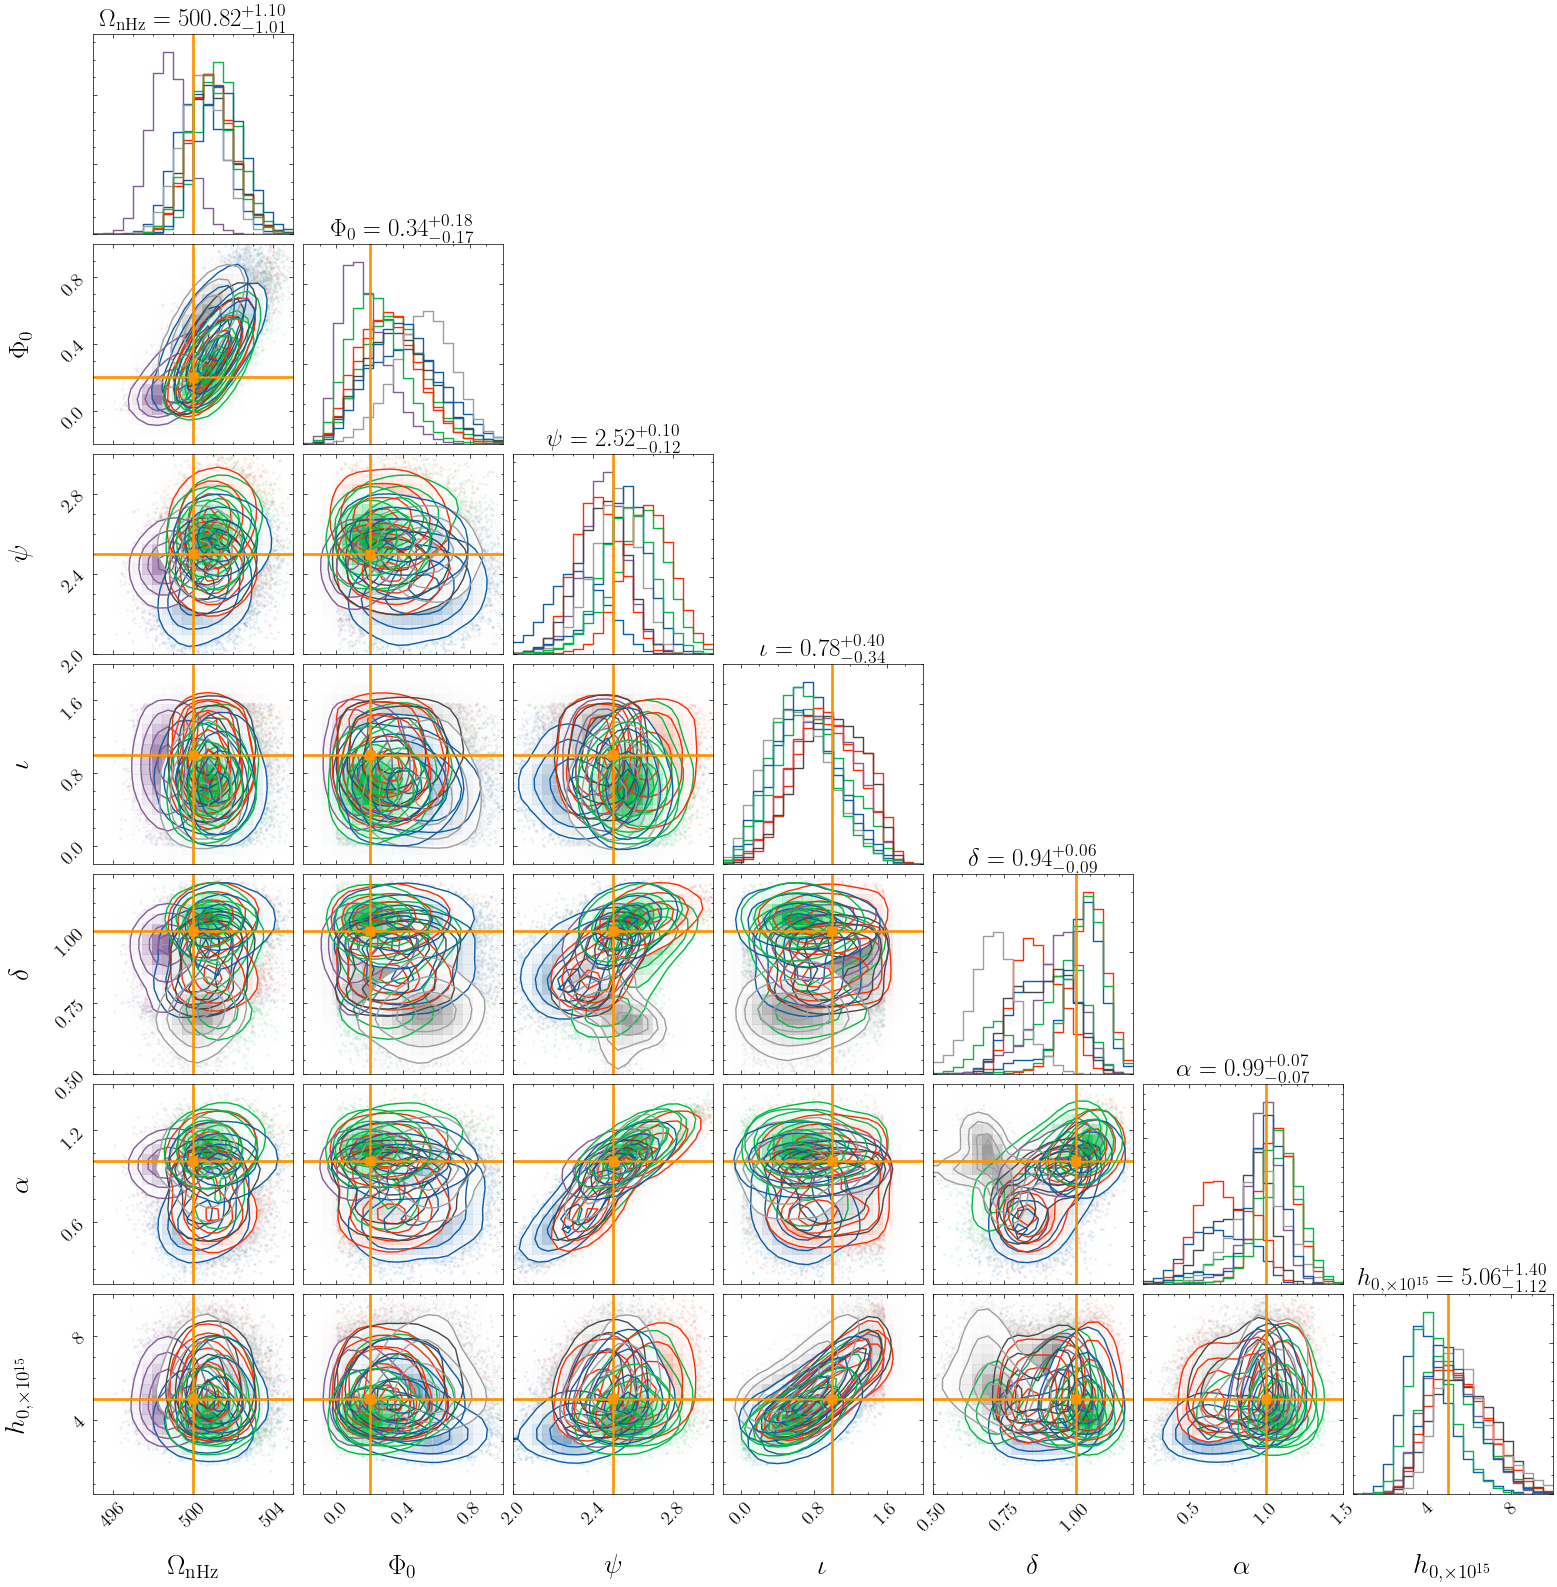

In [38]:


import glob
list_of_files = sorted(glob.glob("../data/nested_sampling/small_h_batch/*"))
list_of_files = list_of_files[65:65+9]


val = 5e-15

ranges=[(495,505),(-0.20,1.00),(2.0,3.0),(-0.2,2.0),(0.5,1.2),(0.2,1.5),(0.1*val*1e15,2.0*val*1e15)]
injection_parameters = [5e-7*1e9,0.20,2.50,1.0,1.0,1.0,val*1e15]
labels = [r'$\Omega_{\text{nHz}}$',r'$\Phi_0$',r'$\psi$',r'$\iota$', r'$\delta$',r'$\alpha$',r'$h_{0, \times 10^{15}}$']
variables_to_plot = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw", "h"]
axes_scales = None

number_of_files_to_plot = 9
stacked_corner(list_of_files,number_of_files_to_plot,variables_to_plot,ranges,injection_parameters,labels,axes_scales,savefig="stacked_GW_plot_small_h_definitive2", logscale=False)

There are 9 noise realisations and 7 parameters.

Of these 63 instances, what fraction haev the injection contained within the 90 % credible interval?

In [39]:

def get_injection_credible_level(path,injection_parameters):

    print(path)
    #Define the parameters 
    parameters = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw","h"]
    assert len(parameters) == len(injection_parameters)

    #Load a file 
    f = open(path)
    data = json.load(f)
    f.close()
    #Make it a dataframe. 
    df_posterior = pd.DataFrame(data["posterior"]["content"]) 


    #Setup
    weights = np.ones(len(df_posterior))

    credible_levels = {parameters[idx]: sum(np.array(df_posterior[parameters[idx]].values <injection_parameters[idx]) * weights) / (sum(weights)) for idx in range(len(parameters))}

    return credible_levels
           



In [40]:


injection_parameters = [5e-7,0.20,2.50,1.0,1.0,1.0,5e-15]

credible_levels = list()
for i in range(len(list_of_files)):
    cc = get_injection_credible_level(list_of_files[i],injection_parameters)
    credible_levels.append(cc)

#Make it a df 
credible_levels = pd.DataFrame(credible_levels)


../data/nested_sampling/small_h_batch/small_h_model_earth_batch_1310_result.json
../data/nested_sampling/small_h_batch/small_h_model_earth_batch_1311_result.json
../data/nested_sampling/small_h_batch/small_h_model_earth_batch_1312_result.json
../data/nested_sampling/small_h_batch/small_h_model_earth_batch_1313_result.json
../data/nested_sampling/small_h_batch/small_h_model_earth_batch_1314_result.json
../data/nested_sampling/small_h_batch/small_h_model_earth_batch_1315_result.json
../data/nested_sampling/small_h_batch/small_h_model_earth_batch_1316_result.json
../data/nested_sampling/small_h_batch/small_h_model_earth_batch_1317_result.json
../data/nested_sampling/small_h_batch/small_h_model_earth_batch_1318_result.json


In [41]:
rows,cols = credible_levels.shape
print(f"Total number of entries = {rows*cols}")

Total number of entries = 63


In [51]:

num_contained = np.sum(np.sum(credible_levels < 0.9))
print(num_contained, num_contained/(rows*cols))

58 0.9206349206349206


i.e. 92 % of the cases are contained within the 90 % credible interval

Which ones are not well behaved?

In [44]:
credible_levels > 0.9 

,omega_gw,phi0_gw,psi_gw,iota_gw,delta_gw,alpha_gw,h
0,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,True,True,False
3,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False
5,False,False,False,False,False,False,False
6,False,False,False,False,True,False,False
7,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False


Ok we can see a couple of "True" for delta_gw and alpha_gw in row 2. Lets plot this to see what it looks like.

json
The evidence is: 585801.5745951422


,omega_gw,phi0_gw,psi_gw,iota_gw,delta_gw,alpha_gw,h,f00,f01,f02,...,distance40,distance41,distance42,distance43,distance44,distance45,distance46,sigma_m,log_likelihood,log_prior
0,504.853494,0.576405,2.566670,1.134977,1.069337,0.986741,4.865288,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585809.519193,4735.845736
1,501.313581,0.792068,2.574909,0.451045,0.799437,0.794454,2.728608,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585810.008408,4756.374336
2,499.388824,0.094496,2.454469,1.306680,0.687571,0.707983,4.209331,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585810.048009,4750.479389
3,502.767294,0.710345,2.220476,1.553398,0.838074,0.699099,4.728896,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585812.345702,4752.986135
4,502.986030,0.805693,2.298841,0.898356,0.778515,0.659742,3.263895,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585812.733431,4750.514116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5492,499.906572,0.126942,2.646957,0.547666,0.996614,0.994524,4.800414,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585827.994166,4742.345445
5493,499.627173,0.011008,2.575980,0.755874,0.937307,0.958096,5.635926,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585828.037863,4761.009359
5494,500.261969,0.179846,2.558787,0.868562,0.944126,0.949800,5.749807,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585828.067521,4741.813000
5495,499.689358,0.070400,2.564005,0.651584,0.973814,0.976696,5.047927,327.847021,205.530699,303.090979,...,6.000000e+10,1.800000e+11,9.708667e+10,1.587000e+11,8.630000e+10,1.666655e+11,1.011000e+11,1.000000e-11,585828.087414,4737.440591


Number of samples:
5497
Truths/Medians/Variances
$\Omega_{\text{nHz}}$ 5e-07 500.90215619761125 0.9540167106125168
$\Phi_0$ 0.2 0.322803598363106 0.027373113154531763
$\psi$ 2.5 2.4205106891834287 0.010880443542057552
$\iota$ 1.0 0.9778039725208917 0.1163591913011295
$\delta$ 1.0 0.8623037271917726 0.005080177348668736
$\alpha$ 1.0 0.7132082812306391 0.025209007018378738
$h_{0, \times 10^{15}}$ 5e-15 5.324611565775086 1.3996293959253967
running with increased label size


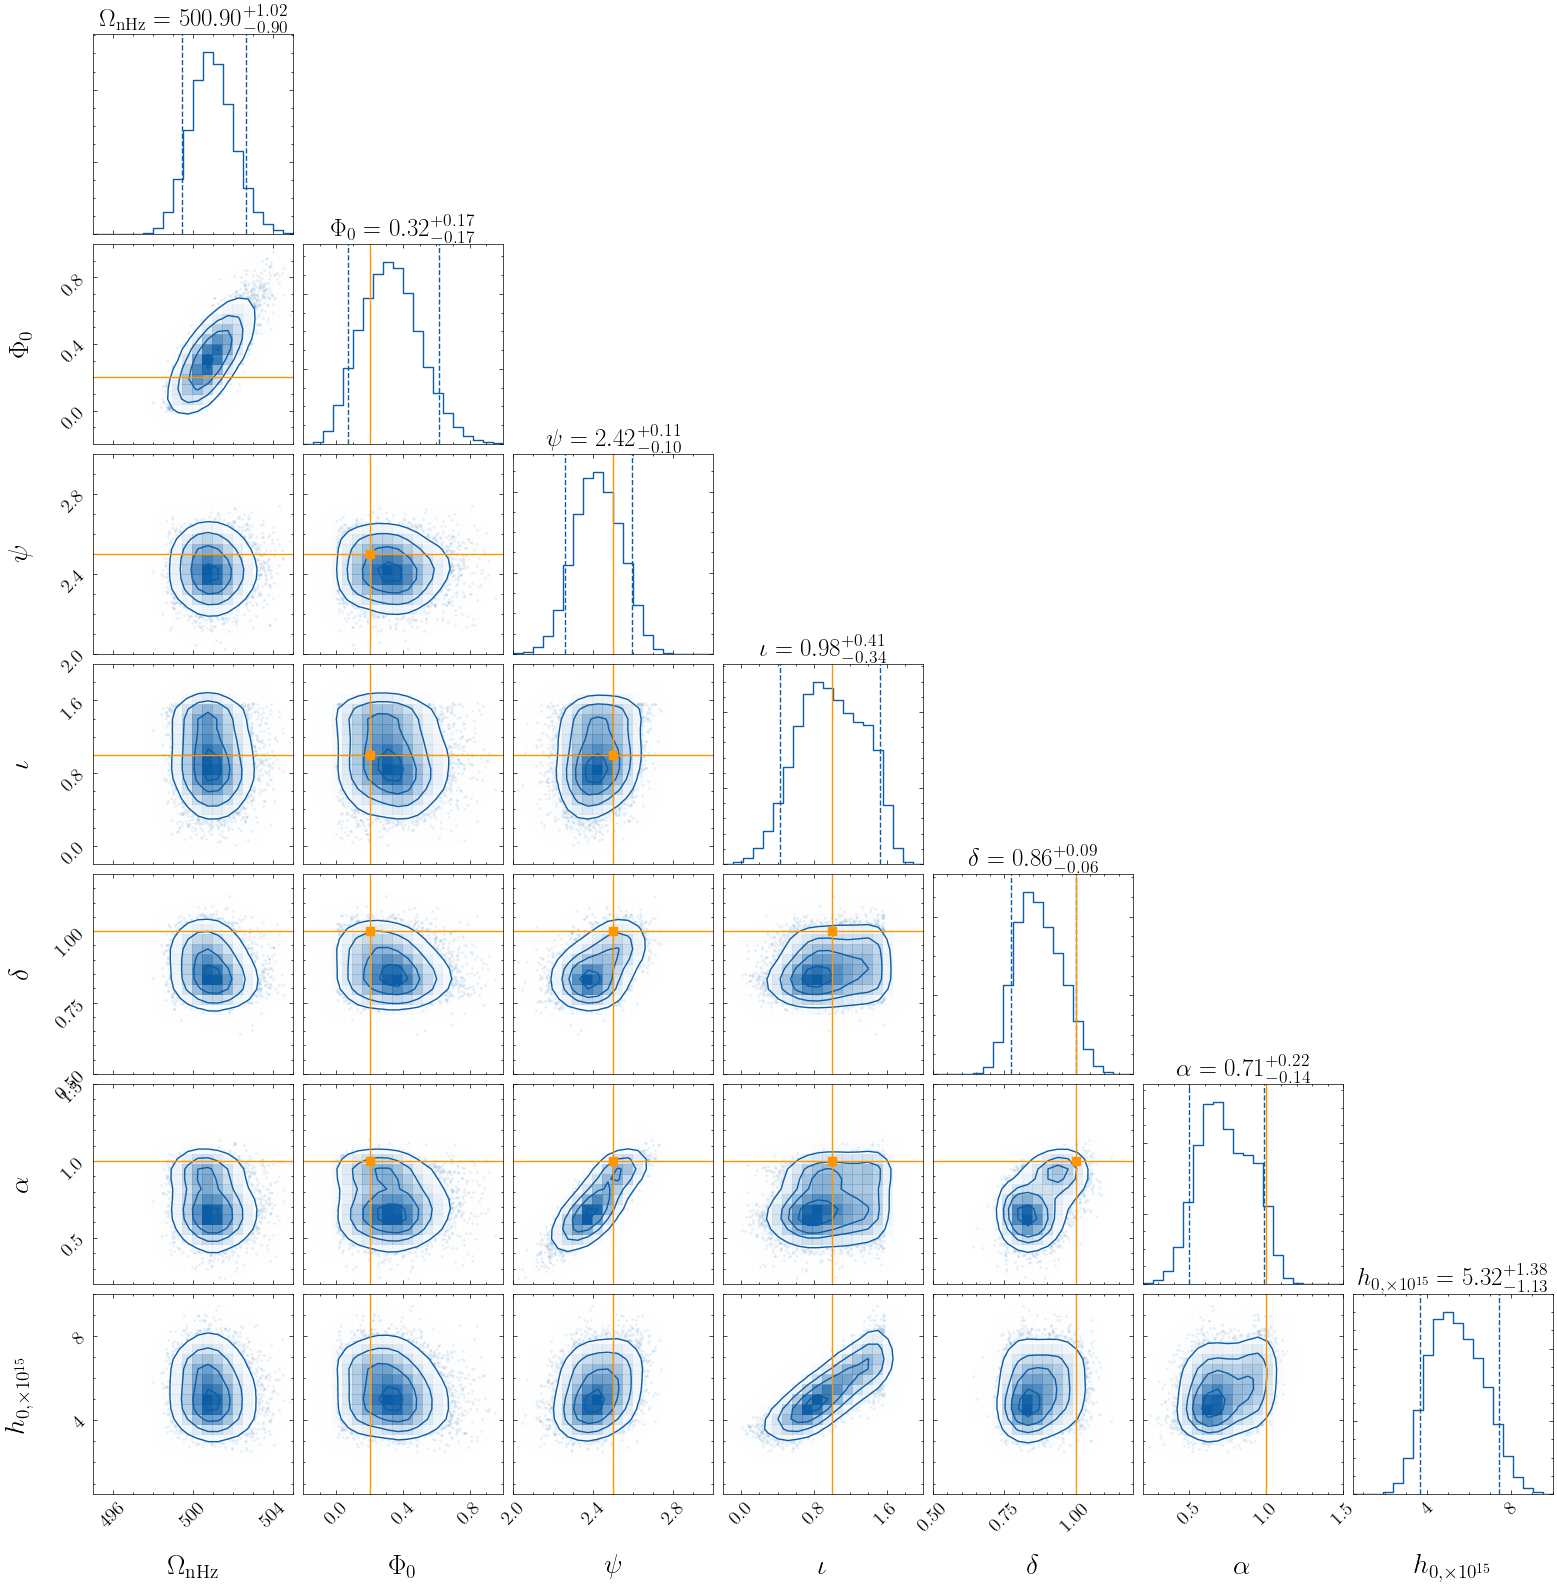

**********************************************************************


In [49]:
from plotting import plot_custom_corner
path = list_of_files[2]
#Corner plot of GW parameters
plot_custom_corner(path,variables_to_plot,labels,injection_parameters,ranges,axes_scales,savefig=None,quantiles =[0.05,0.95],smooth=False,smooth1d=False)



We can see that alpha_gw and delta_gw are just outside 

# Section 5.4, Wasserstein table

In [61]:
def load_data(path,variables_to_plot):

    f = open(path)
    data = json.load(f)
    f.close()
    #Make it a dataframe. 
    df_posterior = pd.DataFrame(data["posterior"]["content"]) 
 
    return df_posterior[variables_to_plot]


def load_data_and_check_for_weird_values(path):



     # Opening JSON file
    f = open(path)
    data = json.load(f)
    f.close()
    #Make it a dataframe. 
    df_posterior = pd.DataFrame(data["posterior"]["content"]) 



    extra_median = df_posterior['psi_gw'].median()
    if extra_median < 1.0: #psi is weird / not converged so don't plot it 
        
        return_code = 1
    else:
        return_code = 0

    return return_code

In [56]:
import glob 

list_of_files = sorted(glob.glob("../data/nested_sampling/small_h_batch/*"))
parameters = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw","h",]
list_of_well_behaved_files = []
for f in list_of_files:
    return_code = load_data_and_check_for_weird_values(f)

    if return_code == 0:
        list_of_well_behaved_files.extend([f])

In [59]:
len(list_of_well_behaved_files) / len(list_of_files)

0.9

In [62]:
#Process all files 


parameters = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw","h",]

all_arrays = []
for f in list_of_well_behaved_files:

    print(i)

    df = load_data(f,parameters)

    numpy_array = df.to_numpy()

    all_arrays.extend([numpy_array])

    i+=1

print("saving")
numpyify = np.array(all_arrays, dtype=object)
outfile = '../data/pairwise_wasserstein'
np.save(outfile, numpyify)



8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
saving


In [66]:
import itertools
new_data = np.load('../data/pairwise_wasserstein.npy',allow_pickle=True)
indexes = list(itertools.combinations(range(len(new_data)), 2))

from scipy.stats import wasserstein_distance
parameters = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw","h"]
wasserstein_results = np.zeros((len(indexes),len(parameters)))
i=0
for a,b in indexes:

    data1 = new_data[a]
    data2 = new_data[b]

    for p in range(len(parameters)):
        data1_slice = data1[:,p]
        data2_slice = data2[:,p]


        w = wasserstein_distance(data1_slice,data2_slice)
        wasserstein_results[i,p] += w 


    i +=1
    

In [67]:
median_values = np.median(wasserstein_results,axis=0)

In [71]:


injection_parameters = [5e-7,0.20,2.50,1.0,1.0,1.0,5e-15]
prior_volume = [5e-6,2*np.pi,2*np.pi,2*np.pi,2*np.pi,2*np.pi,1e-9]

for i in range(len(parameters)):
    print(parameters[i], median_values[i], 100*median_values[i]/injection_parameters[i], 100*median_values[i]/prior_volume[i])


omega_gw 1.0377273827690227e-09 0.20754547655380456 0.020754547655380453
phi0_gw 0.13420631735470986 67.10315867735493 2.1359598801161694
psi_gw 0.1691992282864665 6.767969131458659 2.692889354912518
iota_gw 0.14056764062011112 14.056764062011112 2.2372034843455784
delta_gw 0.09310525865413696 9.310525865413696 1.4818162142655364
alpha_gw 0.168504543008497 16.850454300849698 2.681833095324317
h 8.141041169396659e-16 16.28208233879332 8.141041169396659e-05
